## Prediction Model using activity stats and abuse scores from text model
* TRAIN - we use activity stats from last 2 weeks of every user and the last revid is included in these calculations and the oldest abuse score is discarded so we have only the most recent 14 abuse scores. We only include activity stats that happened upto maxrevid.

* TEST - we use activity stats from last 2 weeks of every user wih activity limited upto maxrevid (from abuse score data). We continue to use 14 abuse scores (excl most recent one) and only include acitivity stats that happened before maxrevid.

* for activity - static 2 week window (most recent)
* for abuse scores - 1 week window and max upto 15 edits for a given user

In [1]:
# import necessary packages
import os
import pandas as pd
import numpy as np
import re
import sys
sys.path.append('/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages')

# set options
pd.options.display.max_colwidth = 50
pd.set_option('display.max_colwidth', -1) 
pd.options.mode.chained_assignment = None  # default='warn'

### Read in train-test data

In [2]:
# TRAIN
df_train = pd.read_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/cr4zy_data/train_abuse_ores_act.txt', sep = '\t')
df_train.shape

(7985, 78)

In [3]:
df_train.tail()

,username,rev_count_0,rev_count_1,rev_count_2,rev_count_3,rev_count_4,rev_count_5,rev_count_6,rev_count_7,rev_count_8,...,goodfaith_score_5,goodfaith_score_6,goodfaith_score_7,goodfaith_score_8,goodfaith_score_9,goodfaith_score_10,goodfaith_score_11,goodfaith_score_12,goodfaith_score_13,goodfaith_score_14
7980,Jonie148,0.166667,0.000000,0.166667,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,...,0.993816,0.995830,0.993281,0.996197,0.990933,0.995804,0.994963,0.995195,NaN,NaN
7981,Jonny2x4,0.555556,0.000000,0.111111,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,...,0.995386,0.995942,0.994741,0.994710,0.995962,0.996297,0.996858,0.995400,NaN,NaN
7982,Jonpatterns,0.044944,0.235955,0.044944,0.011236,0.000000,0.011236,0.000000,0.123596,0.078652,...,0.995966,0.996821,0.985506,0.996183,0.980798,0.996243,NaN,NaN,NaN,NaN
7983,Jontel,0.041237,0.072165,0.082474,0.072165,0.113402,0.041237,0.103093,0.051546,0.195876,...,0.982828,0.995977,0.996200,0.984396,0.994547,0.995731,0.995041,0.996536,0.995776,NaN
7984,Jonytano20,0.050000,0.050000,0.000000,0.050000,0.250000,0.050000,0.100000,0.250000,0.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# TEST
df_test = pd.read_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/cr4zy_data/test_abuse_ores_act.txt', sep = '\t')
df_test.shape

(7985, 78)

In [5]:
df_test['blocked'].value_counts()
#38.6 % blocked
#61.4 % nonblocked

0    4899
1    3086
Name: blocked, dtype: int64

In [6]:
df_test.head()

,username,rev_count_0,rev_count_1,rev_count_2,rev_count_3,rev_count_4,rev_count_5,rev_count_6,rev_count_7,rev_count_8,...,goodfaith_score_5,goodfaith_score_6,goodfaith_score_7,goodfaith_score_8,goodfaith_score_9,goodfaith_score_10,goodfaith_score_11,goodfaith_score_12,goodfaith_score_13,goodfaith_score_14
0,(127.0.0.1),0.142857,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.996484,0.996302,0.994693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(35)moo,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(TIB1017DTIB1018B),1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,(TSB-98989898959359343848438468678378728872402042042844838438438),1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,...(his name isn't Charles),1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# standardize and calculate variance

In [8]:
df_train.columns

Index(['username', 'rev_count_0', 'rev_count_1', 'rev_count_2', 'rev_count_3',
       'rev_count_4', 'rev_count_5', 'rev_count_6', 'rev_count_7',
       'rev_count_8', 'rev_count_9', 'rev_count_10', 'rev_count_11',
       'rev_count_12', 'rev_count_13', 'rev_count_14', 'rev_avglen_0',
       'rev_avglen_1', 'rev_avglen_2', 'rev_avglen_3', 'rev_avglen_4',
       'rev_avglen_5', 'rev_avglen_6', 'rev_avglen_7', 'rev_avglen_8',
       'rev_avglen_9', 'rev_avglen_10', 'rev_avglen_11', 'rev_avglen_12',
       'rev_avglen_13', 'rev_avglen_14', '2wkactivedays', 'blocked',
       'minor_count_norm', 'dlt_count_norm', 'registered', 'abuse_score_1',
       'abuse_score_2', 'abuse_score_3', 'abuse_score_4', 'abuse_score_5',
       'abuse_score_6', 'abuse_score_7', 'abuse_score_8', 'abuse_score_9',
       'abuse_score_10', 'abuse_score_11', 'abuse_score_12', 'abuse_score_13',
       'abuse_score_14', 'damage_score_1', 'damage_score_2', 'damage_score_3',
       'damage_score_4', 'damage_score_5', 'd

In [9]:
# standardize revision length and the calculate variance of length and counts
df_train2 = df_train

# standardization length columns
from sklearn.preprocessing import StandardScaler

df_train2[['rev_avglen_0', 'rev_avglen_1', 'rev_avglen_2', 'rev_avglen_3',
       'rev_avglen_4', 'rev_avglen_5', 'rev_avglen_6', 'rev_avglen_7',
       'rev_avglen_8', 'rev_avglen_9', 'rev_avglen_10', 'rev_avglen_11',
       'rev_avglen_12', 'rev_avglen_13', 'rev_avglen_14']] = StandardScaler().fit_transform(df_train2[['rev_avglen_0', 'rev_avglen_1', 'rev_avglen_2', 'rev_avglen_3',
       'rev_avglen_4', 'rev_avglen_5', 'rev_avglen_6', 'rev_avglen_7',
       'rev_avglen_8', 'rev_avglen_9', 'rev_avglen_10', 'rev_avglen_11',
       'rev_avglen_12', 'rev_avglen_13', 'rev_avglen_14']])

In [10]:
df_train2.columns[1:16]

Index(['rev_count_0', 'rev_count_1', 'rev_count_2', 'rev_count_3',
       'rev_count_4', 'rev_count_5', 'rev_count_6', 'rev_count_7',
       'rev_count_8', 'rev_count_9', 'rev_count_10', 'rev_count_11',
       'rev_count_12', 'rev_count_13', 'rev_count_14'],
      dtype='object')

In [11]:
# calculate variance of count and length
df_train2['revcount_var'] = df_train2.iloc[:,1:16].var(axis=1)
df_train2['revlen_var'] = df_train2.iloc[:,16:31].var(axis=1)

df_train2.drop(columns= ['rev_count_0', 'rev_count_1',
       'rev_count_2', 'rev_count_3', 'rev_count_4', 'rev_count_5',
       'rev_count_6', 'rev_count_7', 'rev_count_8', 'rev_count_9',
       'rev_count_10', 'rev_count_11', 'rev_count_12', 'rev_count_13',
       'rev_count_14', 'rev_avglen_0', 'rev_avglen_1', 'rev_avglen_2',
       'rev_avglen_3', 'rev_avglen_4', 'rev_avglen_5', 'rev_avglen_6',
       'rev_avglen_7', 'rev_avglen_8', 'rev_avglen_9', 'rev_avglen_10',
       'rev_avglen_11', 'rev_avglen_12', 'rev_avglen_13', 'rev_avglen_14'],inplace = True)

df_train2.columns

Index(['username', '2wkactivedays', 'blocked', 'minor_count_norm',
       'dlt_count_norm', 'registered', 'abuse_score_1', 'abuse_score_2',
       'abuse_score_3', 'abuse_score_4', 'abuse_score_5', 'abuse_score_6',
       'abuse_score_7', 'abuse_score_8', 'abuse_score_9', 'abuse_score_10',
       'abuse_score_11', 'abuse_score_12', 'abuse_score_13', 'abuse_score_14',
       'damage_score_1', 'damage_score_2', 'damage_score_3', 'damage_score_4',
       'damage_score_5', 'damage_score_6', 'damage_score_7', 'damage_score_8',
       'damage_score_9', 'damage_score_10', 'damage_score_11',
       'damage_score_12', 'damage_score_13', 'damage_score_14',
       'goodfaith_score_1', 'goodfaith_score_2', 'goodfaith_score_3',
       'goodfaith_score_4', 'goodfaith_score_5', 'goodfaith_score_6',
       'goodfaith_score_7', 'goodfaith_score_8', 'goodfaith_score_9',
       'goodfaith_score_10', 'goodfaith_score_11', 'goodfaith_score_12',
       'goodfaith_score_13', 'goodfaith_score_14', 'revcount_v

In [12]:
# standardize revision length and the calculate variance of length and counts
df_test2 = df_test

# standardization length columns
from sklearn.preprocessing import StandardScaler

df_test2[['rev_avglen_0', 'rev_avglen_1', 'rev_avglen_2', 'rev_avglen_3',
       'rev_avglen_4', 'rev_avglen_5', 'rev_avglen_6', 'rev_avglen_7',
       'rev_avglen_8', 'rev_avglen_9', 'rev_avglen_10', 'rev_avglen_11',
       'rev_avglen_12', 'rev_avglen_13', 'rev_avglen_14']] = StandardScaler().fit_transform(df_test2[['rev_avglen_0', 'rev_avglen_1', 'rev_avglen_2', 'rev_avglen_3',
       'rev_avglen_4', 'rev_avglen_5', 'rev_avglen_6', 'rev_avglen_7',
       'rev_avglen_8', 'rev_avglen_9', 'rev_avglen_10', 'rev_avglen_11',
       'rev_avglen_12', 'rev_avglen_13', 'rev_avglen_14']])

In [13]:
# calculate variance of count and length
df_test2['revcount_var'] = df_test2.iloc[:,1:16].var(axis=1)
df_test2['revlen_var'] = df_test2.iloc[:,16:31].var(axis=1)

df_test2.drop(columns= ['rev_count_0', 'rev_count_1',
       'rev_count_2', 'rev_count_3', 'rev_count_4', 'rev_count_5',
       'rev_count_6', 'rev_count_7', 'rev_count_8', 'rev_count_9',
       'rev_count_10', 'rev_count_11', 'rev_count_12', 'rev_count_13',
       'rev_count_14', 'rev_avglen_0', 'rev_avglen_1', 'rev_avglen_2',
       'rev_avglen_3', 'rev_avglen_4', 'rev_avglen_5', 'rev_avglen_6',
       'rev_avglen_7', 'rev_avglen_8', 'rev_avglen_9', 'rev_avglen_10',
       'rev_avglen_11', 'rev_avglen_12', 'rev_avglen_13', 'rev_avglen_14'],inplace = True)

df_test2.columns

Index(['username', '2wkactivedays', 'blocked', 'minor_count_norm',
       'dlt_count_norm', 'registered', 'abuse_score_1', 'abuse_score_2',
       'abuse_score_3', 'abuse_score_4', 'abuse_score_5', 'abuse_score_6',
       'abuse_score_7', 'abuse_score_8', 'abuse_score_9', 'abuse_score_10',
       'abuse_score_11', 'abuse_score_12', 'abuse_score_13', 'abuse_score_14',
       'damage_score_1', 'damage_score_2', 'damage_score_3', 'damage_score_4',
       'damage_score_5', 'damage_score_6', 'damage_score_7', 'damage_score_8',
       'damage_score_9', 'damage_score_10', 'damage_score_11',
       'damage_score_12', 'damage_score_13', 'damage_score_14',
       'goodfaith_score_1', 'goodfaith_score_2', 'goodfaith_score_3',
       'goodfaith_score_4', 'goodfaith_score_5', 'goodfaith_score_6',
       'goodfaith_score_7', 'goodfaith_score_8', 'goodfaith_score_9',
       'goodfaith_score_10', 'goodfaith_score_11', 'goodfaith_score_12',
       'goodfaith_score_13', 'goodfaith_score_14', 'revcount_v

In [14]:
df_test2.shape

(7985, 50)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy as sp
import numpy as np

vect_c1 = TfidfVectorizer(min_df=0.01,lowercase=True,stop_words='english',norm='l1',ngram_range=(2,5),analyzer='char',max_features=200).fit(df_train2['username'])
df_train_char1 = vect_c1.transform(df_train2['username'])
df_test_char1 = vect_c1.transform(df_test2['username'])

df_train_char2 = pd.DataFrame(df_train_char1.todense())
df_test_char2 = pd.DataFrame(df_test_char1.todense())

df_train_char2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.111804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.296434,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [16]:
df_train_char2.shape

(7985, 200)

In [17]:
df_train3 = pd.concat([df_train2,df_train_char2], axis=1)
df_test3 = pd.concat([df_test2,df_test_char2], axis=1)
df_train3.shape

(7985, 250)

In [18]:
from sklearn import cross_validation

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Test-Train Splitting
* 60% train, 40% test
* class imbalance should get carried into test-train split (61% - 39%)

In [19]:
#df_train3 = df_train2
#df_test3 = df_test2
# mute if not running username features

In [20]:
# splitting on the basis of train
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.testing import assert_equal

X = df_train3.drop('blocked', axis=1) 
y = df_train3['blocked']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
sss.get_n_splits(X, y)
print(sss)       

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.4,
            train_size=None)


In [21]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test_dummy = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test_dummy = y.iloc[train_index], y.iloc[test_index]

TRAIN: [5619 5712  240 ... 2809 1683 3033] TEST: [6073 7026 2593 ... 2611 5982 2169]
TRAIN: [5094 3845 1204 ... 2156 5692  124] TEST: [4404 3150 3741 ... 4388 7071 1058]
TRAIN: [5022 6200 2388 ...  364 4869 4896] TEST: [4409 5250 4560 ... 4281 4291 6229]
TRAIN: [6198 2968 5177 ... 3309 1688 7467] TEST: [4445 4470 7748 ... 7011  686 7938]
TRAIN: [3468 5032 1661 ... 7596 4647 6318] TEST: [1974 2049  383 ... 3227 4570 3261]


In [22]:
# 60-40% split is right
#X_train.shape #4791
X_test_dummy.shape #3194 

(3194, 249)

In [23]:
# lets look at class imbalance
y_test_dummy.value_counts(normalize=True) # so in train/test we have 38% bl and 61% nonbl

0    0.613651
1    0.386349
Name: blocked, dtype: float64

In [24]:
# check for overlaps
#trainind = pd.Index(X_train.index.values)
#testind = pd.Index(X_test_dummy.index.values)
#testind.intersection(trainind)
# yes no overalps exist

In [25]:
df_test3.shape

(7985, 250)

In [26]:
X_test_dummy.shape

(3194, 249)

In [27]:
#y_test
X_test_dummy.head()

,username,2wkactivedays,minor_count_norm,dlt_count_norm,registered,abuse_score_1,abuse_score_2,abuse_score_3,abuse_score_4,abuse_score_5,...,190,191,192,193,194,195,196,197,198,199
1974,DonaldTonald3,1,0.0357,0.0,1,0.766548,0.916431,0.760436,0.640492,0.764199,...,0.000000,0.0,0.0,0.0,0.0,0.134375,0.0,0.0,0.000000,0.0
2049,DuaLipa99,2,0.0000,0.0,1,0.614407,0.492337,0.492337,0.822713,0.864203,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
383,Addust,2,0.0357,0.0,1,0.229221,0.539430,0.258649,0.757385,0.663007,...,0.314951,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.349567,0.0
5137,113.210.75.33,1,0.0000,0.0,0,0.106037,NaN,NaN,NaN,NaN,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
7404,GodeNehler,3,0.7500,0.0,1,0.190589,0.344533,0.438537,0.229104,0.403472,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [28]:
# lets extract index from dummytest and apply to real test set

testindex = y_test_dummy.index.values
X_test_df = df_test3.iloc[testindex]
X_test_df.shape

(3194, 250)

In [29]:
df_in = X_test_df

In [30]:
X_test = X_test_df.drop('blocked', axis=1) 
y_test = X_test_df['blocked']

In [31]:
X_test.head()

,username,2wkactivedays,minor_count_norm,dlt_count_norm,registered,abuse_score_1,abuse_score_2,abuse_score_3,abuse_score_4,abuse_score_5,...,190,191,192,193,194,195,196,197,198,199
1974,DonaldTonald3,1,0.037,0.0,1,0.916431,0.760436,0.640492,0.764199,0.682330,...,0.000000,0.0,0.0,0.0,0.0,0.134375,0.0,0.0,0.000000,0.0
2049,DuaLipa99,2,0.000,0.0,1,0.492337,0.492337,0.822713,0.864203,0.900271,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
383,Addust,2,0.037,0.0,1,0.539430,0.258649,0.757385,0.663007,0.611552,...,0.314951,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.349567,0.0
5137,113.210.75.33,1,0.000,0.0,0,0.104206,NaN,NaN,NaN,NaN,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
7404,GodeNehler,3,0.750,0.0,1,0.344533,0.438537,0.229104,0.403472,0.625949,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [32]:
# lets recheck dimensions of train/test
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(4791, 249) (4791,) (3194, 249) (3194,)


In [33]:
# lets check if indices overalp in train vs test

#X_train_ind = pd.Index(X_train.index.values)
#X_test_ind = pd.Index(X_test.index.values)
#X_train_ind.intersection(X_test_ind) # yes no overalps exist

In [34]:
# check if indices align for train and test
#y_train_ind = pd.Index(y_train.index.values)
#X_train_ind.intersection(y_train_ind) # yes aligned

#y_test_ind = pd.Index(y_test.index.values)
#X_test_ind.intersection(y_test_ind) # yes aligned

In [35]:
X_train = X_train.drop(columns = ['username'])
X_test = X_test.drop(columns = ['username'])

### Splitting data

In [36]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from xgboost.sklearn import XGBClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [37]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4791, 248) (3194, 248) (4791,) (3194,)


### XG Boost on select model to check individual performance

#### Activity only - XGBoost Model

In [38]:
X_train_act = X_train.iloc [:,[0,1,2,3,46,47]]
X_test_act = X_test.iloc [:,[0,1,2,3,46,47]]
print(X_train_act.shape,X_test_act.shape,y_train.shape,y_test.shape)

(4791, 6) (3194, 6) (4791,) (3194,)


In [39]:
# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)
xgb.fit(X_train_act,y_train)

predictions_xgb = xgb.predict(X_test_act)
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_xgb)

[23:22:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:19] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:19] /opt/conda/conda-bld/xgboost_

[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_

[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_

[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_

[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:20] /opt/conda/conda-bld/xgboost_

[23:22:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:21] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [40]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc* 100.0))

Accuracy: 80.31%


AUC: 79.30%


#### Abuse Scores only - XGBoost Model

In [41]:
X_train_abuse = X_train.iloc [:,4:18]
X_test_abuse = X_test.iloc [:,4:18]
print(X_train_abuse.shape,X_test_abuse.shape,y_train.shape,y_test.shape)

(4791, 14) (3194, 14) (4791,) (3194,)


In [42]:
# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)
xgb.fit(X_train_abuse,y_train)

predictions_xgb = xgb.predict(X_test_abuse)
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_xgb)

[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_

[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:24] /opt/conda/conda-bld/xgboost_

[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_

[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_

[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:25] /opt/conda/conda-bld/xgboost_

[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_

[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:26] /opt/conda/conda-bld/xgboost_

[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [43]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc* 100.0))

Accuracy: 77.11%


AUC: 75.09%


#### Ores Scores only - XGBoost Model

In [44]:
X_train_ores = X_train.iloc [:,18:46]
X_test_ores = X_test.iloc [:,18:46]
print(X_train_ores.shape,X_test_ores.shape,y_train.shape,y_test.shape)

(4791, 28) (3194, 28) (4791,) (3194,)


In [45]:
# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)
xgb.fit(X_train_ores,y_train)

predictions_xgb = xgb.predict(X_test_ores)
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_xgb)

[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_

[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:28] /opt/conda/conda-bld/xgboost_

[23:22:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:28] /opt/conda/conda-bld/xgboost_

[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:29] /opt/conda/conda-bld/xgboost_

[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_

[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_

[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_

[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:22:31] /opt/conda/conda-bld/xgboost_

[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [46]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc* 100.0))

Accuracy: 70.70%


AUC: 68.06%


#### Username features only - XGBoost Model

In [47]:
X_train_uname = X_train.iloc [:,48:]
X_test_uname = X_test.iloc [:,48:]
print(X_train_uname.shape,X_test_uname.shape,y_train.shape,y_test.shape)

(4791, 200) (3194, 200) (4791,) (3194,)


In [48]:
# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)
xgb.fit(X_train_uname,y_train)

predictions_xgb = xgb.predict(X_test_uname)
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_xgb)

[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:32] /opt/conda/conda-bld/xgboost_

[23:22:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:34] /opt/conda/conda-bld/xgboost_

[23:22:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:22:35] /opt/conda/conda-bld/xgboost_

[23:22:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:22:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:36] /opt/conda/conda-bld/xgboost_

[23:22:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:22:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:22:38] /opt/conda/conda-bld/xgboost_

[23:22:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:22:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:40] /opt/conda/conda-bld/xgboost_

[23:22:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:41] /opt/conda/conda-bld/xgboost_

[23:22:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:42] /opt/conda/conda-bld/xgboost_

[23:22:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:22:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:44] /opt/conda/conda-bld/xgboost_

[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc* 100.0))

Accuracy: 67.44%


AUC: 66.34%


#### Act + Abuse - XGBoost model

In [50]:
X_train_actabuse = X_train.iloc [:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,46,47]]
X_test_actabuse = X_test.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,46,47]]
print(X_train_actabuse.shape,X_test_actabuse.shape,y_train.shape,y_test.shape)

(4791, 20) (3194, 20) (4791,) (3194,)


In [51]:
X_train_actabuse.head()

,2wkactivedays,minor_count_norm,dlt_count_norm,registered,abuse_score_1,abuse_score_2,abuse_score_3,abuse_score_4,abuse_score_5,abuse_score_6,abuse_score_7,abuse_score_8,abuse_score_9,abuse_score_10,abuse_score_11,abuse_score_12,abuse_score_13,abuse_score_14,revcount_var,revlen_var
3468,1,0.0000,0.0,0,0.420666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066667,0.004856
5032,1,0.0000,0.0,0,0.320272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066667,0.016076
1661,1,0.0000,0.0,1,0.572458,0.764008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066667,0.008303
6513,4,0.0000,0.0,1,0.308740,0.298745,0.624953,0.484016,0.238444,0.389402,0.472919,0.336104,0.295181,0.281281,NaN,NaN,NaN,NaN,0.015238,0.187535
6747,13,0.1364,0.0,1,0.210565,0.299280,0.333540,0.211284,0.335349,0.214441,0.212146,0.569775,0.591487,0.364924,0.212766,0.212209,0.063473,0.100063,0.004812,2.185782


In [52]:
# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)
xgb.fit(X_train_actabuse,y_train)

predictions_xgb = xgb.predict(X_test_actabuse)
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_xgb)

[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_

[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_

[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_

[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:46] /opt/conda/conda-bld/xgboost_

[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_

[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:47] /opt/conda/conda-bld/xgboost_

[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_

[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:48] /opt/conda/conda-bld/xgboost_

[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc* 100.0))

Accuracy: 88.26%


AUC: 86.89%


### Act + Abuse + Ores- XGBoost model

In [54]:
X_train.columns[:48]

Index(['2wkactivedays', 'minor_count_norm', 'dlt_count_norm', 'registered',
       'abuse_score_1', 'abuse_score_2', 'abuse_score_3', 'abuse_score_4',
       'abuse_score_5', 'abuse_score_6', 'abuse_score_7', 'abuse_score_8',
       'abuse_score_9', 'abuse_score_10', 'abuse_score_11', 'abuse_score_12',
       'abuse_score_13', 'abuse_score_14', 'damage_score_1', 'damage_score_2',
       'damage_score_3', 'damage_score_4', 'damage_score_5', 'damage_score_6',
       'damage_score_7', 'damage_score_8', 'damage_score_9', 'damage_score_10',
       'damage_score_11', 'damage_score_12', 'damage_score_13',
       'damage_score_14', 'goodfaith_score_1', 'goodfaith_score_2',
       'goodfaith_score_3', 'goodfaith_score_4', 'goodfaith_score_5',
       'goodfaith_score_6', 'goodfaith_score_7', 'goodfaith_score_8',
       'goodfaith_score_9', 'goodfaith_score_10', 'goodfaith_score_11',
       'goodfaith_score_12', 'goodfaith_score_13', 'goodfaith_score_14',
       'revcount_var', 'revlen_var'],
   

In [55]:
X_train_actabuseores = X_train.iloc[:,:48]
X_test_actabuseores = X_test.iloc[:,:48]
print(X_train_actabuseores.shape,X_test_actabuseores.shape,y_train.shape,y_test.shape)

(4791, 48) (3194, 48) (4791,) (3194,)


In [56]:
# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)
xgb.fit(X_train_actabuseores,y_train)

predictions_xgb = xgb.predict(X_test_actabuseores)
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_xgb)

[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:22:49] /opt/conda/conda-bld/xgboost_

[23:22:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:22:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:22:50] /opt/conda/conda-bld/xgboost_

[23:22:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:22:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:51] /opt/conda/conda-bld/xgboost_

[23:22:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:22:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:22:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:52] /opt/conda/conda-bld/xgboost_

[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_

[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:22:53] /opt/conda/conda-bld/xgboost_

[23:22:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:22:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:22:55] /opt/conda/conda-bld/xgboost_

[23:22:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:22:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:56] /opt/conda/conda-bld/xgboost_

[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [57]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc* 100.0))

Accuracy: 92.30%


AUC: 91.38%


#### Act + Abuse + Ores + Username - XGBoost (whole model)

In [58]:
X_train_actabuseoresuname = X_train.iloc[:,:]
X_test_actabuseoresuname = X_test.iloc[:,:]
print(X_train_actabuseoresuname.shape,X_test_actabuseoresuname.shape,y_train.shape,y_test.shape)

(4791, 248) (3194, 248) (4791,) (3194,)


In [59]:
# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)
xgb.fit(X_train_actabuseoresuname,y_train)

predictions_xgb = xgb.predict(X_test_actabuseoresuname)
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_xgb)

[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:22:57] /opt/conda/conda-bld/xgboost_

[23:22:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:22:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:22:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:22:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:22:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:22:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:00] /opt/conda/conda-bld/xgboost_

[23:23:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:02] /opt/conda/conda-bld/xgboost_

[23:23:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:03] /opt/conda/conda-bld/xgboost_

[23:23:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:23:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:23:06] /opt/conda/conda-bld/xgboost_

[23:23:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:23:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:08] /opt/conda/conda-bld/xgboost_

[23:23:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:10] /opt/conda/conda-bld/xgboost_

[23:23:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:12] /opt/conda/conda-bld/xgboost_

[23:23:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:23:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:14] /opt/conda/conda-bld/xgboost_

[23:23:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:16] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [60]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc* 100.0))

Accuracy: 92.61%


AUC: 92.00%


In [61]:
# ends here

### Running the whole model with cross validation

In [62]:
print(X_train.shape,X_test.shape)

(4791, 248) (3194, 248)


In [63]:
# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)

params = {'n_estimators':[500]}
xgb_cv = GridSearchCV(estimator=xgb,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=3,
                  verbose=1)

xgb_cv.fit(X_train, y_train)

best_parameters = xgb_cv.best_params_  
print("best parameters are",best_parameters) 

best_result = xgb_cv.best_score_  
print("Best Score is",best_result)


predictions_xgb = xgb_cv.best_estimator_.predict_proba(X_test) # predict with best params
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_xgb)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[23:23:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:23:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:23:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:23:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:23:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:23:17] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned 

[23:23:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:23:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:23:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:23:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:23:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:23:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:23:18] /opt/conda/conda-bld/xgboost_

[23:23:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:23:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:23:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:23:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:23:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:23:20] /opt/conda/conda-bld/xgboost_

[23:23:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:21] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:21] /opt/conda/conda-bld/xgboost_

[23:23:23] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:23:23] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:23] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:23] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:23:23] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:23] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:23] /opt/conda/conda-bld/xgboost_

[23:23:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:24] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:24] /opt/conda/conda-bld/xgboost_

[23:23:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:26] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:26] /opt/conda/conda-bld/xgboost_

[23:23:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:27] /opt/conda/conda-bld/xgboost_

[23:23:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:29] /opt/conda/conda-bld/xgboost_

[23:23:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:30] /opt/conda/conda-bld/xgboost_

[23:23:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:32] /opt/conda/conda-bld/xgboost_

[23:23:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:23:33] /opt/conda/conda-bld/xgboost_

[23:23:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:23:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:35] /opt/conda/conda-bld/xgboost_

[23:23:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:23:36] /opt/conda/conda-bld/xgboost_

[23:23:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:23:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:37] /opt/conda/conda-bld/xgboost_

[23:23:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:23:39] /opt/conda/conda-bld/xgboost_

[23:23:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:23:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:41] /opt/conda/conda-bld/xgboost_

[23:23:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:42] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:42] /opt/conda/conda-bld/xgboost_

[23:23:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:44] /opt/conda/conda-bld/xgboost_

[23:23:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:23:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:23:45] /opt/conda/conda-bld/xgboost_

[23:23:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:47] /opt/conda/conda-bld/xgboost_

[23:23:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:48] /opt/conda/conda-bld/xgboost_

[23:23:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:50] /opt/conda/conda-bld/xgboost_

[23:23:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:51] /opt/conda/conda-bld/xgboost_

[23:23:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:23:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:53] /opt/conda/conda-bld/xgboost_

[23:23:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:23:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:23:55] /opt/conda/conda-bld/xgboost_

[23:23:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:23:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:23:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:23:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:23:56] /opt/conda/conda-bld/xgboost_

[23:23:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:23:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:23:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:58] /opt/conda/conda-bld/xgboost_

[23:23:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:23:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:23:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:23:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:23:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:24:00] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.5s finished


[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:24:01] /opt/conda/conda-bld/xgboost_

[23:24:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:24:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:24:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:24:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:24:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:03] /opt/conda/conda-bld/xgboost_

[23:24:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:24:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:24:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:24:06] /opt/conda/conda-bld/xgboost_

[23:24:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:24:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:08] /opt/conda/conda-bld/xgboost_

[23:24:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:24:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:24:10] /opt/conda/conda-bld/xgboost_

[23:24:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:24:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:24:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:24:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:24:12] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:12] /opt/conda/conda-bld/xgboost_

[23:24:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:24:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:24:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:14] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:14] /opt/conda/conda-bld/xgboost_

[23:24:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:24:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:24:16] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:24:16] /opt/conda/conda-bld/xgboost_

[23:24:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:24:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:24:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:24:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:18] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:24:18] /opt/conda/conda-bld/xgboost_

[23:24:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:24:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:24:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:24:20] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:24:20] /opt/conda/conda-bld/xgboost_

TypeError: type numpy.ndarray doesn't define __round__ method

In [64]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc* 100.0))
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, predictions))
print('\n')

Accuracy: 92.61%


AUC: 92.00%


=== Confusion Matrix ===
[[1856  104]
 [ 132 1102]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.93      0.95      0.94      1960
          1       0.91      0.89      0.90      1234

avg / total       0.93      0.93      0.93      3194





In [65]:
predictions_xgb.shape

(3194, 2)

In [66]:
# computing threshold
df_predprob = pd.DataFrame(predictions_xgb)
df_predprob = df_predprob.iloc[:,1]
df_predprob.columns = ['blocked_prob']
df_predprob.head()

0    0.999358
1    0.996153
2    0.989411
3    0.000767
4    0.008640
Name: 1, dtype: float32

In [67]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [68]:
p, r, thresholds = precision_recall_curve(y_test, df_predprob)

In [69]:
def adjusted_classes(df_predprob, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in df_predprob]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(df_predprob, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    df_pred = [1 if y >= t else 0 for y in df_predprob]
    accuracy = accuracy_score(y_test, df_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, df_pred))
    print('\n')

    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg  1726      234     
pos  63        1171    
Accuracy: 90.70%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.96      0.88      0.92      1960
          1       0.83      0.95      0.89      1234

avg / total       0.91      0.91      0.91      3194





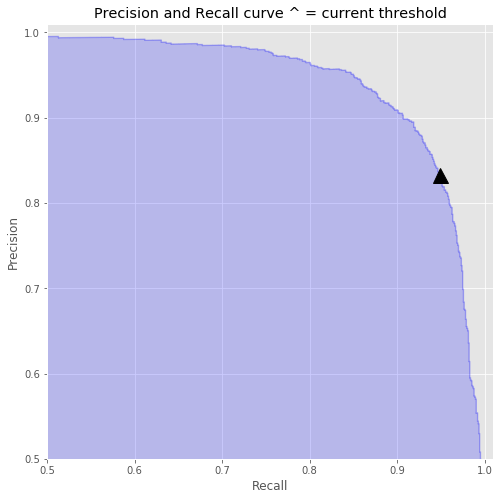

In [70]:
precision_recall_threshold(p,r,thresholds,t=0.1) # original, matches matrix above

     pred_neg  pred_pos
neg  1791      169     
pos  87        1147    
Accuracy: 91.98%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.95      0.91      0.93      1960
          1       0.87      0.93      0.90      1234

avg / total       0.92      0.92      0.92      3194





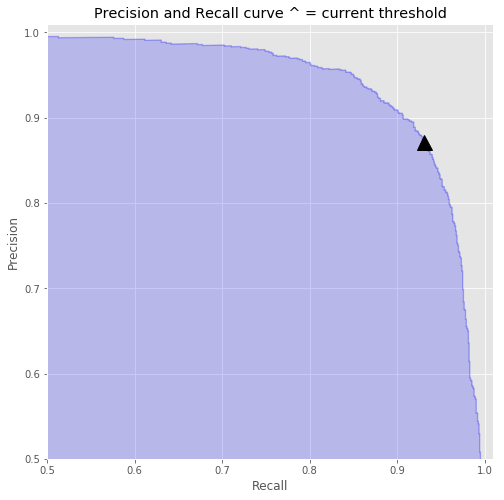

In [71]:
precision_recall_threshold(p,r,thresholds,t=0.2)

     pred_neg  pred_pos
neg  1827      133     
pos  100       1134    
Accuracy: 92.71%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.95      0.93      0.94      1960
          1       0.90      0.92      0.91      1234

avg / total       0.93      0.93      0.93      3194





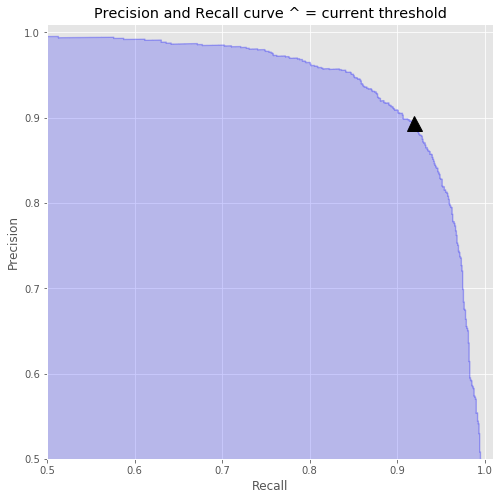

In [72]:
precision_recall_threshold(p,r,thresholds,t=0.3)

     pred_neg  pred_pos
neg  1843      117     
pos  120       1114    
Accuracy: 92.58%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.94      0.94      0.94      1960
          1       0.90      0.90      0.90      1234

avg / total       0.93      0.93      0.93      3194





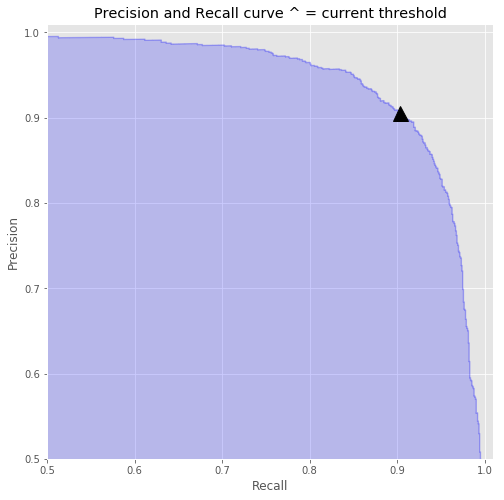

In [73]:
precision_recall_threshold(p,r,thresholds,t=0.4)

     pred_neg  pred_pos
neg  1856      104     
pos  132       1102    
Accuracy: 92.61%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.93      0.95      0.94      1960
          1       0.91      0.89      0.90      1234

avg / total       0.93      0.93      0.93      3194





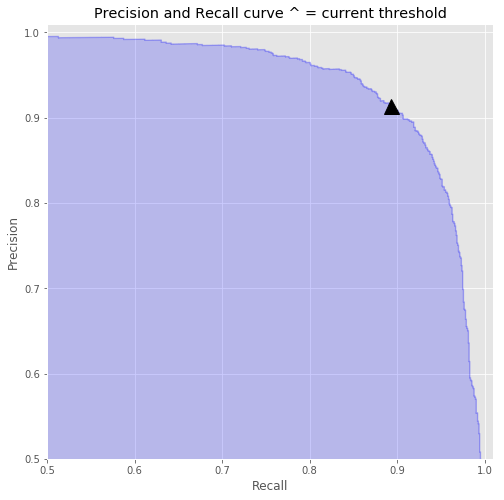

In [74]:
precision_recall_threshold(p,r,thresholds,t=0.5)

     pred_neg  pred_pos
neg  1870      90      
pos  150       1084    
Accuracy: 92.49%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.93      0.95      0.94      1960
          1       0.92      0.88      0.90      1234

avg / total       0.92      0.92      0.92      3194





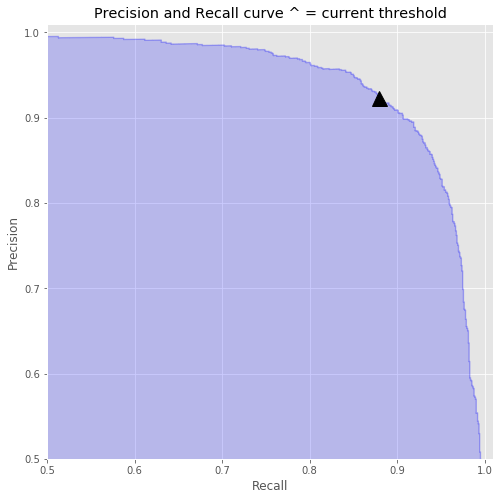

In [75]:
precision_recall_threshold(p,r,thresholds,t=0.6)

     pred_neg  pred_pos
neg  1887      73      
pos  168       1066    
Accuracy: 92.45%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.92      0.96      0.94      1960
          1       0.94      0.86      0.90      1234

avg / total       0.93      0.92      0.92      3194





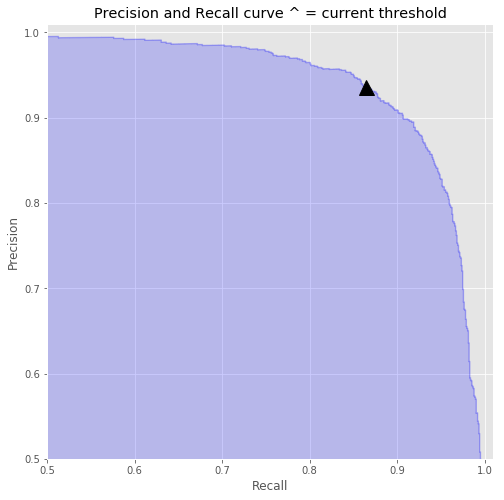

In [76]:
precision_recall_threshold(p,r,thresholds,t=0.7)

     pred_neg  pred_pos
neg  1907      53      
pos  188       1046    
Accuracy: 92.45%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      1960
          1       0.95      0.85      0.90      1234

avg / total       0.93      0.92      0.92      3194





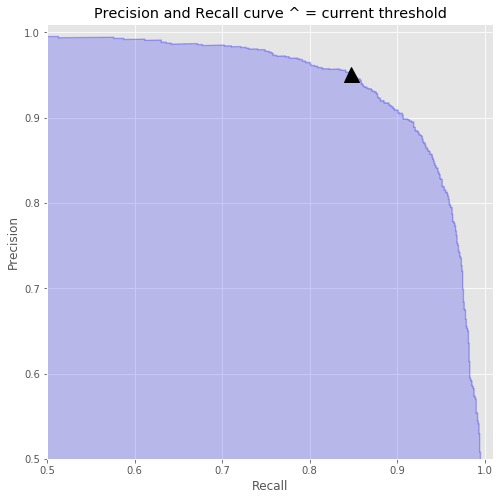

In [77]:
precision_recall_threshold(p,r,thresholds,t=0.8)

     pred_neg  pred_pos
neg  1930      30      
pos  265       969     
Accuracy: 90.76%


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.88      0.98      0.93      1960
          1       0.97      0.79      0.87      1234

avg / total       0.91      0.91      0.91      3194





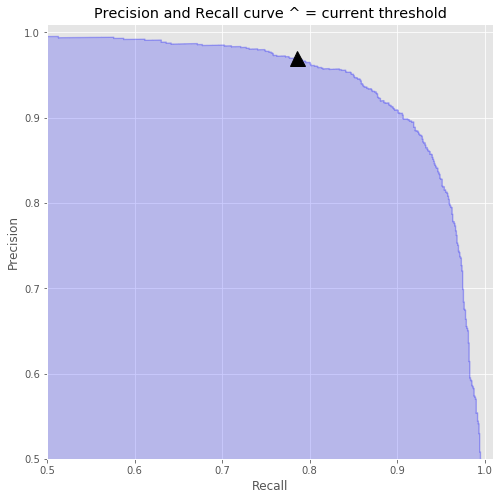

In [78]:
precision_recall_threshold(p,r,thresholds,t=0.9)

### Feature Importance

In [79]:
# refit to check model feature importance

# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)
xgb.fit(X_train,y_train)

predictions_xgb = xgb.predict(X_test)
predictions = [round(value) for value in predictions_xgb]

feature_importances = pd.DataFrame(xgb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)


[23:24:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:24:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:24:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:24:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:24:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:24:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:24:49] /opt/conda/conda-bld/xgboost_

[23:24:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:24:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:24:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:24:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:24:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:51] /opt/conda/conda-bld/xgboost_

[23:24:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:24:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:24:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:24:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:24:53] /opt/conda/conda-bld/xgboost_

[23:24:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:24:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:24:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:24:56] /opt/conda/conda-bld/xgboost_

[23:24:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:24:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:24:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:24:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:58] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:58] /opt/conda/conda-bld/xgboost_

[23:24:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:24:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:24:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:24:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:24:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:24:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:25:00] /opt/conda/conda-bld/xgboost_

[23:25:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:25:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:25:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:25:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:25:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:25:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:25:01] /opt/conda/conda-bld/xgboost_

[23:25:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:25:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:25:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:25:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:25:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:25:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:25:03] /opt/conda/conda-bld/xgboost_

[23:25:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:25:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:25:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:25:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:25:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:25:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:25:06] /opt/conda/conda-bld/xgboost_

[23:25:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:25:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:25:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:25:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:25:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:25:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:25:08] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [80]:
feature_importances[0:10]

,importance
revlen_var,0.044987
abuse_score_1,0.042577
damage_score_1,0.038400
goodfaith_score_1,0.035508
damage_score_2,0.034062
abuse_score_3,0.033580
abuse_score_2,0.031812
goodfaith_score_2,0.029724
abuse_score_4,0.028920
damage_score_3,0.025868


### Dump output into dataframe

In [ ]:
# dump output into dataframe
predictions_df = pd.DataFrame(predictions)
predictions_df['index'] = pd.Index(df_in.index.values)
predictions_df = predictions_df.set_index('index')
predictions_df.columns = ['pred_label']
#predictions_df
#predictions_df.shape

df_in1 = df_in.iloc[:,:50]
df_out = pd.merge(df_in1,predictions_df,how = 'left',left_index = True, right_index = True)
print(df_out.shape)

In [ ]:
df_out.head(10)

In [ ]:
df_out.columns

In [ ]:
# save file as .csv
header = ['username', '2wkactivedays', 'blocked', 'minor_count_norm',
       'dlt_count_norm', 'registered', 'abuse_score_1', 'abuse_score_2',
       'abuse_score_3', 'abuse_score_4', 'abuse_score_5', 'abuse_score_6',
       'abuse_score_7', 'abuse_score_8', 'abuse_score_9', 'abuse_score_10',
       'abuse_score_11', 'abuse_score_12', 'abuse_score_13', 'abuse_score_14',
       'damage_score_1', 'damage_score_2', 'damage_score_3', 'damage_score_4',
       'damage_score_5', 'damage_score_6', 'damage_score_7', 'damage_score_8',
       'damage_score_9', 'damage_score_10', 'damage_score_11',
       'damage_score_12', 'damage_score_13', 'damage_score_14',
       'goodfaith_score_1', 'goodfaith_score_2', 'goodfaith_score_3',
       'goodfaith_score_4', 'goodfaith_score_5', 'goodfaith_score_6',
       'goodfaith_score_7', 'goodfaith_score_8', 'goodfaith_score_9',
       'goodfaith_score_10', 'goodfaith_score_11', 'goodfaith_score_12',
       'goodfaith_score_13', 'goodfaith_score_14', 'revcount_var',
       'revlen_var', 'pred_label']

df_out.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/cr4zy_data/test_output.txt', sep = '\t',encoding='utf-8',header = True,index=False)

### Implementing other algorithms

### Replace NAN with -1

In [81]:
X_test = X_test.fillna(0)
X_train = X_train.fillna(0)

### Linear SVM

In [82]:
#SVM
lin_clf = LinearSVC(penalty='l1',dual=False)

params = {'C': [0.05, 0.1, 1, 5, 10, 50]}
gs_lin_clf = GridSearchCV(estimator=lin_clf,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=2,
                  verbose=3)

gs_lin_clf.fit(X_train, y_train)

best_parameters = gs_lin_clf.best_params_  
print("best parameters are",best_parameters) 

best_result = gs_lin_clf.best_score_  
print("Best Score is",best_result)

# refit with best parameter
predictions_lin_svc = gs_lin_clf.best_estimator_.predict(X_test) 

# evaluate
auc = roc_auc_score(y_test, predictions_lin_svc)
accuracy = accuracy_score(y_test, predictions_lin_svc)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] C=0.05 ..........................................................
[CV] C=0.05 ..........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] ................. C=0.05, score=0.8835073068893529, total=   0.3s
[CV] C=1 .............................................................
[CV] ................. C=0.05, score=0.8802170283806344, total=   0.5s
[CV] C=1 .............................................................
[CV] .................. C=0.1, score=0.8906510851419032, total=   0.6s
[CV] C=5 .............................................................
[CV] .................. C=0.1, score=0.8847599164926931, total=   0.7s
[CV] C=5 .............................................................
[CV] .................... C=1, score=0.8902337228714524, total=   1.0s
[CV] C=10 .......

[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.1s remaining:    0.6s


[CV] ................... C=50, score=0.8789649415692822, total=   1.6s
[CV] ................... C=50, score=0.8638830897703549, total=   1.3s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.8s finished


best parameters are {'C': 0.1}
Best Score is 0.8877061156334795


In [83]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc * 100.0))
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions_lin_svc))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test,predictions_lin_svc))
print('\n')

Accuracy: 89.29%


AUC: 88.23%


=== Confusion Matrix ===
[[1821  139]
 [ 203 1031]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.90      0.93      0.91      1960
          1       0.88      0.84      0.86      1234

avg / total       0.89      0.89      0.89      3194





### Logistic Classifier

In [84]:
# Logistic Regression
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

params = {'C':[1, 5, 10, 15, 20, 50]}
#C is inverse of regularization strength
gs = GridSearchCV(estimator=clf,
                  param_grid=params,
                  scoring='accuracy',
                  n_jobs=-1,
                  cv=2,
                  verbose=5)
gs.fit(X_train, y_train)

best_parameters = gs.best_params_  
print("best parameters are",best_parameters) 

best_result = gs.best_score_  
print("Best Score is",best_result)

# refit with best parameter
predictions_log = gs.best_estimator_.predict(X_test)

# evaluate
auc = roc_auc_score(y_test, predictions_log)
accuracy = accuracy_score(y_test, predictions_log)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=5 .............................................................
[CV] C=5 .............................................................
[CV] .................... C=1, score=0.8923205342237062, total=   0.2s
[CV] C=10 ............................................................
[CV] ..................... C=1, score=0.886847599164927, total=   0.4s
[CV] C=10 ............................................................
[CV] .................... C=5, score=0.8852253756260434, total=   0.6s
[CV] C=15 ............................................................
[CV] .................... C=5, score=0.8768267223382046, total=   1.2s
[CV] C=15 ............................................................
[CV] ................... C=10, score=0.8831385642737897, total=   1.2s
[CV] C=20 .......

[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:    3.7s remaining:    1.9s


[CV] ................... C=15, score=0.8751565762004175, total=   2.9s
[CV] ................... C=50, score=0.8802170283806344, total=   2.4s
[CV] .................... C=20, score=0.872651356993737, total=   3.4s
[CV] ................... C=50, score=0.8684759916492694, total=   2.8s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.6s finished


best parameters are {'C': 1}
Best Score is 0.8895846378626592


In [85]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc * 100.0))
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions_log))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test,predictions_log))
print('\n')

Accuracy: 89.54%


AUC: 88.60%


=== Confusion Matrix ===
[[1818  142]
 [ 192 1042]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.90      0.93      0.92      1960
          1       0.88      0.84      0.86      1234

avg / total       0.90      0.90      0.90      3194





### Random Forest

In [86]:
# Random Forest
rf = RandomForestClassifier(oob_score='True')
params = {'max_depth': [100], 'n_estimators':[500]}
gs_w = GridSearchCV(estimator=rf,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=2,
                  verbose=5)

gs_w.fit(X_train, y_train)

best_parameters = gs_w.best_params_  
print("best parameters are",best_parameters) 

best_result = gs_w.best_score_  
print("Best Score is",best_result)

# refit with best parameter
predictions_rf_w = gs_w.best_estimator_.predict(X_test)

# evaluate
auc = roc_auc_score(y_test, predictions_rf_w)
accuracy = accuracy_score(y_test, predictions_rf_w)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] max_depth=100, n_estimators=500 .................................
[CV] max_depth=100, n_estimators=500 .................................
[CV]  max_depth=100, n_estimators=500, score=0.9173622704507512, total=   3.1s
[CV]  max_depth=100, n_estimators=500, score=0.9093945720250521, total=   4.5s


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s finished


best parameters are {'max_depth': 100, 'n_estimators': 500}
Best Score is 0.9133792527656022


In [87]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc * 100.0))
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions_rf_w))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test,predictions_rf_w))
print('\n')

Accuracy: 92.14%


AUC: 91.14%


=== Confusion Matrix ===
[[1873   87]
 [ 164 1070]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.92      0.96      0.94      1960
          1       0.92      0.87      0.90      1234

avg / total       0.92      0.92      0.92      3194





### XGB with no Nan = 0 

In [88]:
# XGB
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5,reg_alpha=0.05)

params = {'n_estimators':[500]}
xgb_cv = GridSearchCV(estimator=xgb,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=3,
                  verbose=1)

xgb_cv.fit(X_train, y_train)

best_parameters = xgb_cv.best_params_  
print("best parameters are",best_parameters) 

best_result = xgb_cv.best_score_  
print("Best Score is",best_result)


predictions_xgb = xgb_cv.best_estimator_.predict_proba(X_test) # predict with best params
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions_xgb)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[23:27:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:27:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:27:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:27:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:27:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:27:27] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned 

[23:27:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[23:27:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:27:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:27:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:27:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[23:27:28] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:27:28] /opt/conda/conda-bld/xgboost_

[23:27:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:27:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:27:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:27:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:27:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:27:29] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:27:29] /opt/conda/conda-bld/xgboost_

[23:27:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:27:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[23:27:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:30] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:30] /opt/conda/conda-bld/xgboost_

[23:27:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:27:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:31] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:31] /opt/conda/conda-bld/xgboost_

[23:27:32] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:27:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:33] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:33] /opt/conda/conda-bld/xgboost_

[23:27:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:27:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:27:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:34] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:34] /opt/conda/conda-bld/xgboost_

[23:27:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:35] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:35] /opt/conda/conda-bld/xgboost_

[23:27:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:36] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[23:27:36] /opt/conda/conda-bld/xgboost_

[23:27:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:37] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:38] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:38] /opt/conda/conda-bld/xgboost_

[23:27:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:39] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:39] /opt/conda/conda-bld/xgboost_

[23:27:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:40] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:40] /opt/conda/conda-bld/xgboost_

[23:27:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:41] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:41] /opt/conda/conda-bld/xgboost_

[23:27:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:43] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:27:43] /opt/conda/conda-bld/xgboost_

[23:27:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:27:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:44] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:27:44] /opt/conda/conda-bld/xgboost_

[23:27:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:45] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:27:45] /opt/conda/conda-bld/xgboost_

[23:27:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:27:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:27:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:46] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:27:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:47] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:47] /opt/conda/conda-bld/xgboost_

[23:27:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:48] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:48] /opt/conda/conda-bld/xgboost_

[23:27:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:27:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:49] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:49] /opt/conda/conda-bld/xgboost_

[23:27:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:50] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:50] /opt/conda/conda-bld/xgboost_

[23:27:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:27:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:51] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:51] /opt/conda/conda-bld/xgboost_

[23:27:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:52] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:52] /opt/conda/conda-bld/xgboost_

[23:27:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:53] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:54] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:54] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:54] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:54] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:54] /opt/conda/conda-bld/xgboost_

[23:27:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:27:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:55] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:55] /opt/conda/conda-bld/xgboost_

[23:27:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:27:56] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:56] /opt/conda/conda-bld/xgboost_

[23:27:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:27:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:27:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:27:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:27:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:27:57] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:27:57] /opt/conda/conda-bld/xgboost_

[23:27:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:27:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:27:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:27:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:27:59] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:27:59] /opt/conda/conda-bld/xgboost_

[23:28:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:28:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:28:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:28:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:28:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:28:00] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:28:00] /opt/conda/conda-bld/xgboost_

[23:28:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:28:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:28:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:28:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:28:01] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:28:01] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:02] /opt/conda/conda-bld/xgboost_

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[23:28:02] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.9s finished


[23:28:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:28:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:28:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:28:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:28:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:28:03] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:28:03] /opt/conda/conda-bld/xgboost_

[23:28:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:28:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:28:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:28:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:04] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:28:04] /opt/conda/conda-bld/xgboost_

[23:28:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[23:28:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:28:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:28:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[23:28:05] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:28:05] /opt/conda/conda-bld/xgboost_

[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_

[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:28:06] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:28:07] /opt/conda/conda-bld/xgboost_

[23:28:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:28:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[23:28:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[23:28:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:28:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:28:07] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:28:07] /opt/conda/conda-bld/xgboost_

[23:28:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:28:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:28:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:28:08] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:28:08] /opt/conda/conda-bld/xgboost_

[23:28:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:28:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[23:28:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[23:28:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:28:09] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:28:09] /opt/conda/conda-bld/xgboost_

[23:28:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[23:28:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:28:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[23:28:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:28:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[23:28:10] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[23:28:10] /opt/conda/conda-bld/xgboost_

[23:28:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[23:28:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[23:28:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[23:28:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[23:28:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[23:28:11] /opt/conda/conda-bld/xgboost_1541449690605/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[23:28:11] /opt/conda/conda-bld/xgboost_

TypeError: type numpy.ndarray doesn't define __round__ method

In [89]:
# evaluation results
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('\n')
print("AUC: %.2f%%" %(auc* 100.0))
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, predictions))
print('\n')

Accuracy: 92.14%


AUC: 91.14%


=== Confusion Matrix ===
[[1856  104]
 [ 132 1102]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.93      0.95      0.94      1960
          1       0.91      0.89      0.90      1234

avg / total       0.93      0.93      0.93      3194



